In [7]:
import sys
sys.path.append('..')
import os, json, pickle
import matplotlib.pyplot as plt
import numpy as np
import re
from utils.spectrum import read_spectrum, denorm_spectrum, norm_spectrum, spectrum_psnrs
from utils.visualize import plot_map, plot_maxmap

model_root = 'D:/MODELS/super_res/dbpn/'
data_root  = 'x:/DATA/2D/pl_postech/spectrum/'

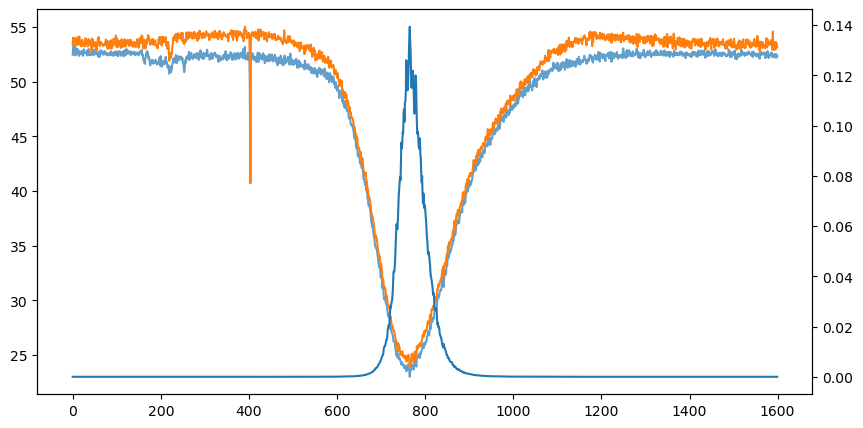

In [29]:
f, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(spectrum_psnrs(norm_tgt, norm_bic), alpha=0.7)
ax.plot(spectrum_psnrs(norm_tgt, norm_pred))
var = np.var(norm_tgt.reshape(norm_tgt.shape[0], -1), axis=1)
_ = ax.twinx().plot(var)
print(np.average(nor))

19



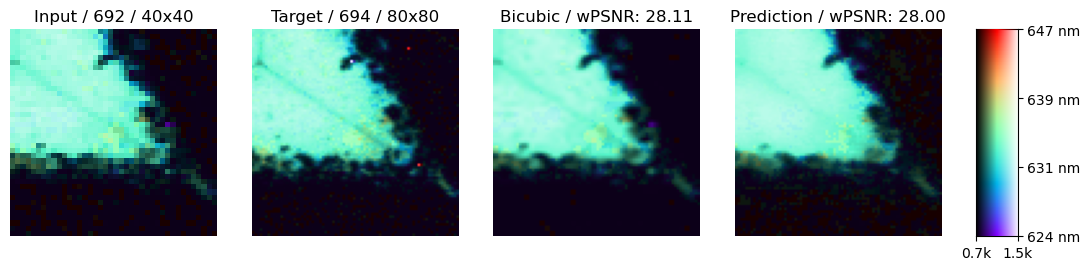

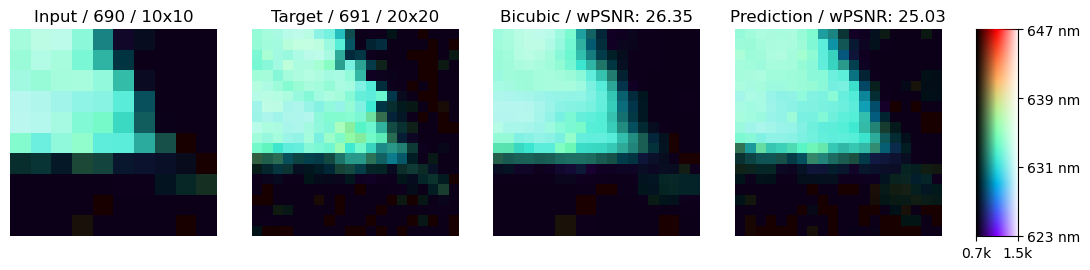

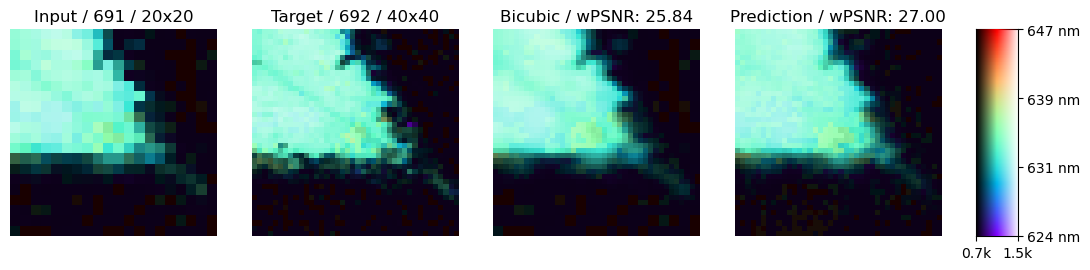

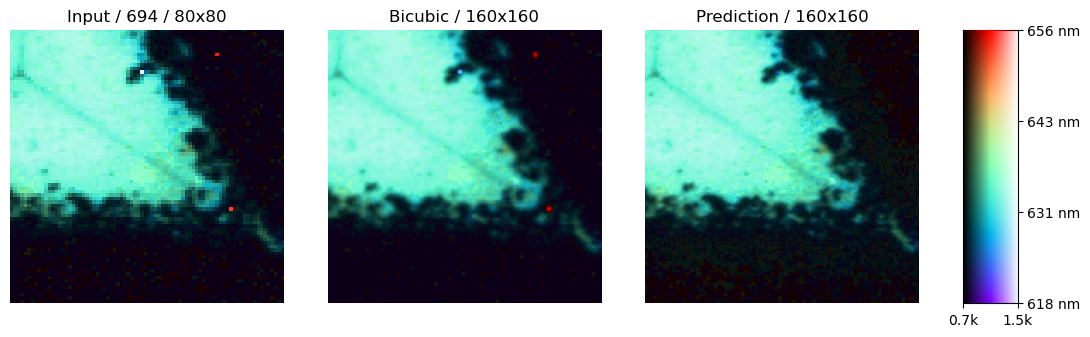

In [158]:
path = 'cvd_ws2/finetune/rgb_00_2x_mixed'

with open(os.path.join(model_root, path, 'best.epoch.txt')) as f:
    print(f.read())
with open(os.path.join(model_root, path, '00090.valid.pkl'),'rb') as f:
    d = pickle.load(f)
r = re.compile('[^0-9,]')
for k, v in d.items():
    f, axs = plt.subplots(1, 5, figsize=(13, 4), gridspec_kw={'width_ratios':[1,1,1,1,0.2]})
    i1, i2 = r.sub('', k).split(',')
    x, ys_inp = read_spectrum(i1, root=data_root, transpose_y=True)
    r1 = ys_inp.shape[1]
    x, ys_tgt = read_spectrum(i2, root=data_root, transpose_y=True)
    r2 = ys_tgt.shape[1]
    n = x.shape[0]

    vmin, vmax = v['vmin'], v['vmax']
    _x = v['x']
    norm_tgt  = v['tgt'][:, 0]
    norm_pred = np.mean(v['pred'], axis=1)
    norm_pred = v['pred'][:, 2]
    norm_bic  = v['bic'][:, 0]
    _x = _x[np.var(norm_bic.reshape(n, -1), axis=1) > 0.01]
    xrange = [np.min(_x), np.max(_x)]
    yrange = [vmin, vmax]
    pred = denorm_spectrum(norm_pred, vmin=vmin, vmax=vmax)
    bic = denorm_spectrum(norm_bic, vmin=vmin, vmax=vmax)
    tgt = denorm_spectrum(norm_tgt, vmin=vmin, vmax=vmax)
    var = np.var(norm_tgt.reshape(n, -1), axis=1)
    psnr_bic = np.average(spectrum_psnrs(norm_tgt, norm_bic), weights=var)
    psnr_pred = np.average(spectrum_psnrs(norm_tgt, norm_pred), weights=var)
    axs[0].set_title(f'Input / {i1} / {r1}x{r1}')
    axs[1].set_title(f'Target / {i2} / {r2}x{r2}')
    axs[2].set_title(f'Bicubic / wPSNR: {psnr_bic:.2f}')
    axs[3].set_title(f'Prediction / wPSNR: {psnr_pred:.2f}')
    plot_maxmap(axs[0], x, ys_inp, xrange=xrange, yrange=yrange)
    plot_maxmap(axs[1], x, ys_tgt, xrange=xrange, yrange=yrange)
    plot_maxmap(axs[2], x, bic, xrange=xrange, yrange=yrange)
    plot_maxmap(axs[3], x, pred, xrange=xrange, yrange=yrange, cax=axs[-1], aspect_ratio=5)

with open(os.path.join(model_root, path, '00090.test.pkl'),'rb') as f:
    d = pickle.load(f)
r = re.compile('[^0-9,]')
for k, v in d.items():
    i1, _ = r.sub('', k).split(',')
    x, ys_inp = read_spectrum(i1, root=data_root, transpose_y=True)
    n = x.shape[0]
    vmin, vmax = v['vmin'], v['vmax']
    _x = v['x']
    norm_pred = np.mean(v['pred'], axis=1)
    norm_bic  = v['bic'][:, 0]
    _x = _x[np.var(norm_bic.reshape(n, -1), axis=1) > 0.001]
    xrange = [np.min(_x), np.max(_x)]
    yrange = [vmin, vmax]
    pred = denorm_spectrum(norm_pred, vmin=vmin, vmax=vmax)
    bic = denorm_spectrum(norm_bic, vmin=vmin, vmax=vmax)
    f, axs = plt.subplots(1, 4, figsize=(13, 4), gridspec_kw={'width_ratios':[1,1,1,0.2]})
    r1 = ys_inp.shape[1]
    r2 = pred.shape[1]
    axs[0].set_title(f'Input / {i1} / {r1}x{r1}')
    axs[1].set_title(f'Bicubic / {r2}x{r2}')
    axs[2].set_title(f'Prediction / {r2}x{r2}')
    plot_maxmap(axs[0], x, ys_inp, xrange=xrange, yrange=yrange)
    plot_maxmap(axs[1], x, bic, xrange=xrange, yrange=yrange)
    plot_maxmap(axs[2], x, pred, xrange=xrange, yrange=yrange, cax=axs[-1], aspect_ratio=5)

In [147]:
stride = 5
n = ys_inp.shape[0]
_y = ys_inp#[:, np.newaxis, ...]
ys_inp_rgb = np.stack([_y[stride*2:], _y[stride:-stride], _y[:-stride*2]], axis=-1)
ys_inp_rgb
vmin, vmax, norm_rgb = norm_spectrum(ys_inp_rgb, ys_inp)
_, _, norm_grey = norm_spectrum(ys_inp, vmin=vmin, vmax=vmax)
#_y = np.arange(100)
#_y = _y[..., np.newaxis]
#np.concatenate([_y[:-stride*2], _y[stride:-stride], _y[stride*2:]], axis=1)

In [56]:

from PIL import Image

Image.fromarray(norm_rgb[830], mode='RGB'), Image.fromarray(norm_grey[830], mode='L')

NameError: name 'norm_rgb' is not defined

In [53]:
import sys
sys.path.append('..')
from utils.image import *
import pandas as pd
import tqdm, time

df = pd.read_csv('x:/DATA/2D/pl_postech/super_resolution_metadata_20221025.csv')
mult = (df.RES2 / df.RES1).values
mask = ((mult == 2) | (mult == 4) | (mult == 8)) & (df.PL == 1)
idxs = list(sorted(set(df.loc[mask, ['IDX1','IDX2']].values.reshape(-1))))

def read_spectrums(idxs):
    spectrums = {}
    for idx in tqdm.tqdm(idxs):
        x, ys = read_spectrum(idx, transpose_y=True)
        vmin, vmax, nys = norm_spectrum(ys, ref=ys)
        spectrums[idx] = (x,vmin,vmax,ys,nys)
    return spectrums

specs = read_spectrums(idxs)

100%|██████████| 140/140 [03:12<00:00,  1.37s/it]


In [86]:
def get_counts(spectrums):
    counts = {}
    for idx, (x, vmin, vmax, ys, nys) in tqdm.tqdm(spectrums.items()):
        count = []
        n = nys.shape[0]
        vars = np.array([np.var(iy) for iy in nys])
        for i in range(1, 64):
            count.append(np.sum(vars > i) / n)
        counts[idx] = count
    return counts

counts = get_counts(specs)

100%|██████████| 140/140 [00:03<00:00, 45.05it/s]


In [169]:
x, vmin, vmax, ys, nys = specs[724]
imgs = [Image.fromarray(iy, mode='L') for iy in nys]


%timeit v1 = np.array([np.var(img)/255**2 for img in imgs])
%timeit v2 = np.array([np.var(np.array(img)/255) for img in imgs])

45 ms ± 508 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
46.2 ms ± 1.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


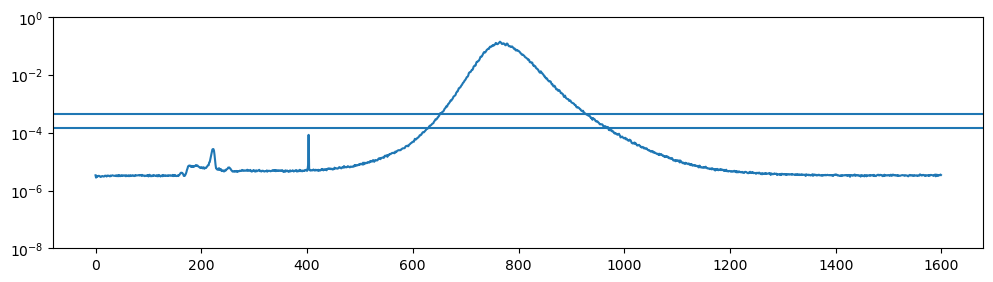

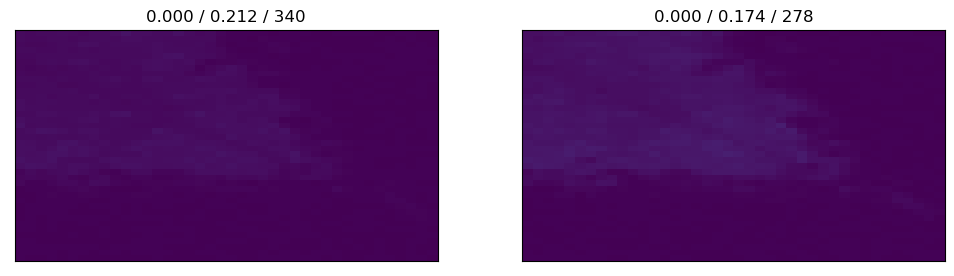

In [234]:
x, vmin, vmax, ys, nys = specs[692]
imgs = [Image.fromarray(iy, mode='L') for iy in nys]
vars = np.array([np.var(img)/255**2 for img in imgs])
count, bins = np.histogram(vars, bins=500)
bins = (bins[1:] + bins[:-1]) * 0.5
i = np.argmax(count)
vcuts = [bins[i], bins[i+1]]
f, ax = plt.subplots(1,1,figsize=(12, 3))
ax.plot(vars)
ax.set_yscale('log')
ax.set_ylim([1e-8, 1])
for vcut in vcuts: ax.axhline(vcut)
f, axs = plt.subplots(1, len(vcuts), figsize=(12, 3))
for ax, vcut in zip(axs, vcuts):
    loc = x[np.argmin(np.abs(vars - vcut))]
    ax.set_title(f'{vcut:.3f} / {np.sum(vars > vcut) / x.shape[0]:.3f} / {np.sum(vars > vcut)}')
    plot_map(ax, x, nys, loc=loc, vmin=0, vmax=256)

In [264]:
def get_neighbors(imgs, num_frames, frame_stride):
    frame_stride = np.max([frame_stride, 1]).astype(int)
    n = len(imgs)
    h = np.max([num_frames // 2, 1])

    ys_nbr = []
    for i in range(n):
        nbr = []
        for j in range(-h, -h+num_frames):
            j = i + j * frame_stride
            if j == i: 
                continue
            if j < 0:
                j = 0
            elif j > n - 1:
                j = n - 1
            #nbr.append(imgs[j])
            nbr.append(j)
        ys_nbr.append((i, nbr))
    return ys_nbr
nbr = get_neighbors(imgs, num_frames=5, frame_stride=5)

In [267]:
nbr[-10:]

[(1590, [1580, 1585, 1595, 1599, 1599]),
 (1591, [1581, 1586, 1596, 1599, 1599]),
 (1592, [1582, 1587, 1597, 1599, 1599]),
 (1593, [1583, 1588, 1598, 1599, 1599]),
 (1594, [1584, 1589, 1599, 1599, 1599]),
 (1595, [1585, 1590, 1599, 1599, 1599]),
 (1596, [1586, 1591, 1599, 1599, 1599]),
 (1597, [1587, 1592, 1599, 1599, 1599]),
 (1598, [1588, 1593, 1599, 1599, 1599]),
 (1599, [1589, 1594, 1599, 1599, 1599])]

In [217]:
np.array(imgs, dtype=object)


#[np.where(vars > vcuts[1])[0]]

C:\Users\Yang\AppData\Local\Temp\ipykernel_332\38410811.py:1: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  np.array(imgs, dtype=object)


array([<PIL.Image.Image image mode=L size=80x80 at 0x18937E588B0>,
       <PIL.Image.Image image mode=L size=80x80 at 0x18937E58940>,
       <PIL.Image.Image image mode=L size=80x80 at 0x18937E58970>, ...,
       <PIL.Image.Image image mode=L size=80x80 at 0x188D08F8820>,
       <PIL.Image.Image image mode=L size=80x80 at 0x188D08F8850>,
       <PIL.Image.Image image mode=L size=80x80 at 0x188D08F8880>],
      dtype=object)

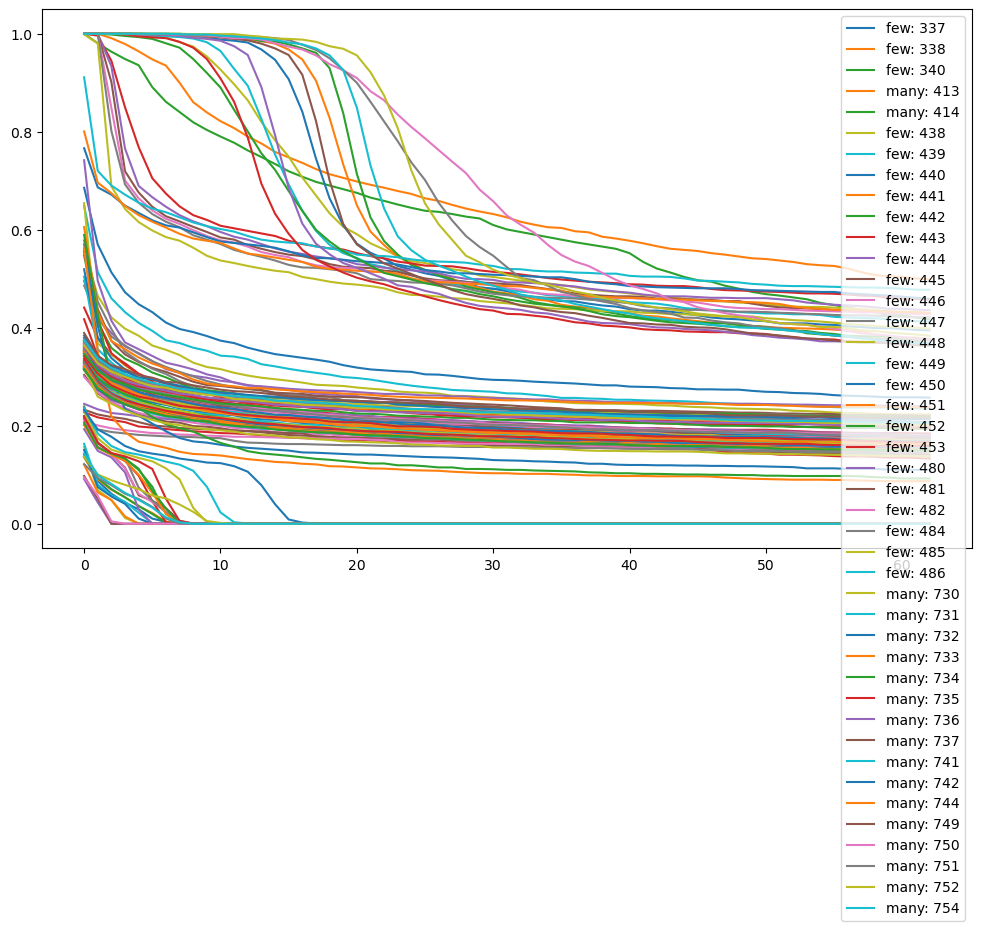

In [92]:
f, ax = plt.subplots(1,1,figsize=(12, 7))
odd_idxs = []
for idx, count in counts.items():
    count_ = count
    if count_[24] > 0.5: 
        ax.plot(count_, label=f'many: {idx}')
    elif count_[24] < 0.01:
        ax.plot(count_, label=f'few: {idx}')
    else:
        ax.plot(count_)
    
ax.legend(loc='upper right')

In [266]:
x, vmin, vmax, ys, nys = specs[721]

In [280]:
imgs = np.repeat(np.arange(10).reshape(-1,1), 9, axis=-1).reshape(-1,3,3,1)

In [283]:
imgs.shape,  np.vstack([imgs[5:], [imgs[-1]] * 5]).shape

((10, 3, 3, 1), (10, 3, 3, 1))

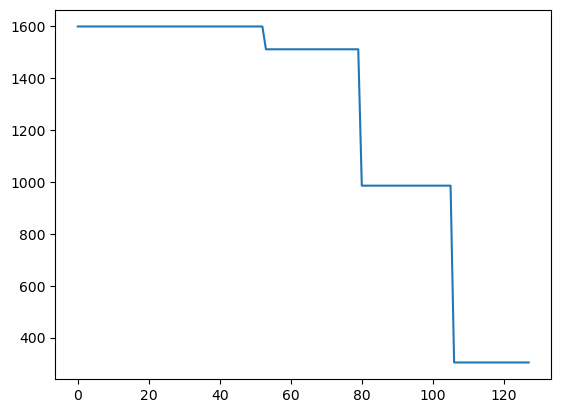

In [249]:
plt.plot(counts[402])

In [227]:
ys.shape, x.shape

((1600, 5, 5), (1600,))

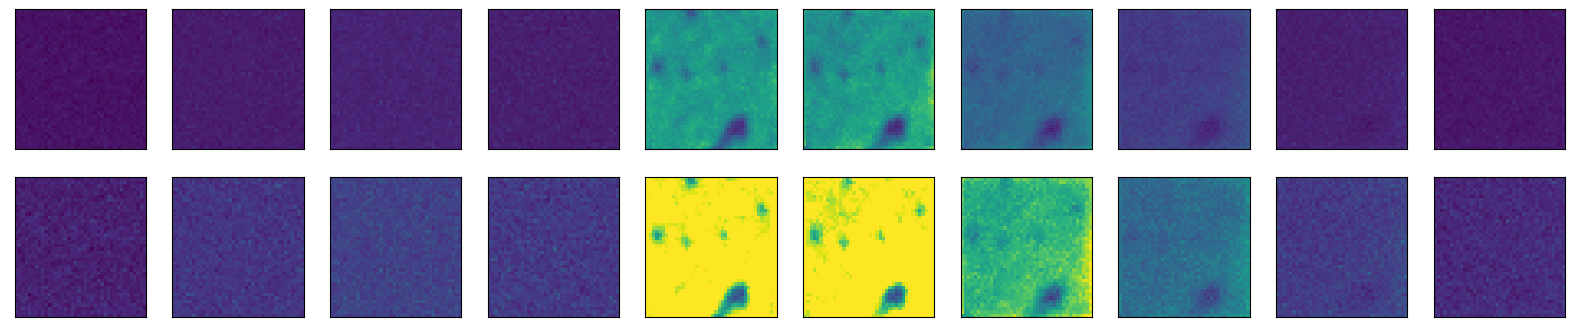

In [69]:
def plot_map(ax, x, ys, loc, tol=0.3, grid=None, readout='max', 
             grid_params={'color':[1,1,1], 'lw':0.8, 'ls':'--'}, 
             **kwargs):
    shape = ys.shape
    if len(shape) == 2:
        i = (np.where(np.array(shape) == x.shape[0])[0] + 1)
        if i == 0: ys = ys.T
        ni = np.sqrt(ys.shape[0]).astype(int)
    elif len(shape) == 3:
        if shape[0] != shape[1]:
            ys = ys.transpose(1, 2, 0)
        ys = ys.reshape(-1, x.shape[0])
        ni = shape[1]
    else:
        raise ValueError('Invalid shape of ys (2-dim or 3-dim)', shape)
    mask = np.abs(x - loc) < tol
    mat = eval(f'np.{readout}(ys[:, mask], axis=1).reshape(ni, ni)')
    
    im = ax.pcolormesh(mat, **kwargs)
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticklabels([])
    ax.set_yticks([])

    if grid and isinstance(grid, int):
        for i in range(ni // grid):
            ax.axhline(i*grid, **grid_params)
            ax.axvline(i*grid, **grid_params)
    return im

x, vmin, vmax, ys, nys = specs[754]
unique = np.unique(nys.reshape(-1))
ls = np.linspace(np.min(x), np.max(x), 10)
f,axs = plt.subplots(2,len(ls),figsize=(20,4))
for ax, l in zip(axs[0], ls):
    plot_map(ax, x, nys, loc=l, vmin=0, vmax=256)
for ax, l in zip(axs[1], ls):
    plot_map(ax, x, nys, loc=l, vmin=0, vmax=128)

In [259]:
np.round(unique/np.sort(unique)[1])

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [243]:
nys[20]

array([[26, 26, 26,  0,  0,  0, 26, 51, 51, 51],
       [26, 26,  0,  0, 26, 51, 26, 51, 77, 51],
       [51, 51, 26, 26, 51, 26,  0,  0, 26, 26],
       [ 0,  0, 26, 26, 26, 26, 51, 51, 26,  0],
       [ 0, 26,  0, 26, 51, 26, 26, 26,  0, 26],
       [ 0, 26, 51, 26,  0,  0, 26,  0, 26, 51],
       [51, 26,  0,  0,  0, 26, 26, 26,  0,  0],
       [ 0,  0,  0, 26, 26, 26,  0,  0, 26, 26],
       [26,  0,  0, 26, 26, 26, 51, 51, 51, 26],
       [26, 26, 26,  0, 26, 26, 51, 51, 51,  0]], dtype=uint8)

(60, 60)

# re-parsing outputs

In [132]:
import os, pickle, tqdm
import numpy as np
import sys
sys.path.append('..')
from utils.spectrum import denorm_spectrum, save_spectrum, read_spectrum

root = '/mnt/MODELS/super_res/pl/s84_cvd_ws2/dbpn/finetune/'
dirs = os.listdir(root)
for dir in dirs:
    path_dir = os.path.join(root, dir)
    if '2x' in path_dir:
        mul = '2x'
    elif '4x' in path_dir:
        mul = '4x'
    else:
        print(path_dir)
        continue
    fns = [fn for fn in os.listdir(path_dir) if fn.endswith('.pkl')]
#    for fn in fns:
    for fn in tqdm.tqdm(fns, desc=dir):
        path_fn = os.path.join(path_dir, fn)
        with open(path_fn, 'rb') as f:
            data = pickle.load(f)
        os.remove(path_fn)

        dirname = os.path.join(path_dir, fn.replace('.pkl',''))
        os.makedirs(dirname, exist_ok=True)
        for k, v in data.items():
            i1, i2 = k.replace('(','').replace(')','').replace(',',' ').replace('_',' ').split()
            if i2 == 'None':
                sname = '_'.join([i1, mul]) + '.txt'
            else:
                sname = '_'.join([i1, mul, i2]) + '.txt'
#        print(dirname)
            vmin, vmax, x, pred = v['vmin'], v['vmax'], v['x'], v['pred']
            if len(pred.shape) == 4:
                pred = pred[:, 0]
            ys = denorm_spectrum(pred, vmin, vmax)
            save_spectrum(x=x, ys=ys, fn=sname, root=dirname)


s05_4x_all: 100%|██████████| 22/22 [09:25<00:00, 25.69s/it]


In [131]:

root = '/mnt/MODELS/super_res/pl/s84_cvd_ws2/rbpn'
for tune in os.listdir(root):
    dirs = os.listdir(os.path.join(root, tune))
    for dir in dirs:
        path_dir = os.path.join(root, tune, dir)
        if '2x' in path_dir:
            mul = '2x'
        elif '4x' in path_dir:
            mul = '4x'
        else:
            print(path_dir)
            continue
        fns = [fn for fn in os.listdir(os.path.join(path_dir, 'output'))]
    #    for fn in fns:
        for fn in tqdm.tqdm(fns, desc=tune + ' / ' + dir):
            epoch, dset, name, sfx = fn.split('.')
            dname = '.'.join([epoch, dset])
            os.makedirs(os.path.join(path_dir, dname), exist_ok=True)
            fname = name.replae('_',f'_{mul}_').replace('_None','.txt')
            os.rename(
                os.path.join(path_dir, 'output', fn),
                os.path.join(path_dir, dname, fname)
            )


basetune / cs00_2x_all: 100%|██████████| 45/45 [00:00<00:00, 662258.53it/s]


00010.test.694_None.txt
00010.valid.691_692.txt
00010.valid.692_694.txt
00020.test.694_None.txt
00020.valid.691_692.txt
00020.valid.692_694.txt
00030.test.694_None.txt
00030.valid.691_692.txt
00030.valid.692_694.txt
00040.test.694_None.txt
00040.valid.691_692.txt
00040.valid.692_694.txt
00050.test.694_None.txt
00050.valid.691_692.txt
00050.valid.692_694.txt
00060.test.694_None.txt
00060.valid.691_692.txt
00060.valid.692_694.txt
00070.test.694_None.txt
00070.valid.691_692.txt
00070.valid.692_694.txt
00080.test.694_None.txt
00080.valid.691_692.txt
00080.valid.692_694.txt
00090.test.694_None.txt
00090.valid.691_692.txt
00090.valid.692_694.txt
00100.test.694_None.txt
00100.valid.691_692.txt
00100.valid.692_694.txt
00110.test.694_None.txt
00110.valid.691_692.txt
00110.valid.692_694.txt
00120.test.694_None.txt
00120.valid.691_692.txt
00120.valid.692_694.txt
00130.test.694_None.txt
00130.valid.691_692.txt
00130.valid.692_694.txt
00140.test.694_None.txt
00140.valid.691_692.txt
00140.valid.692_

basetune / cs05_2x_all: 100%|██████████| 45/45 [00:00<00:00, 720395.73it/s]


00010.test.694_None.txt
00010.valid.691_692.txt
00010.valid.692_694.txt
00020.test.694_None.txt
00020.valid.691_692.txt
00020.valid.692_694.txt
00030.test.694_None.txt
00030.valid.691_692.txt
00030.valid.692_694.txt
00040.test.694_None.txt
00040.valid.691_692.txt
00040.valid.692_694.txt
00050.test.694_None.txt
00050.valid.691_692.txt
00050.valid.692_694.txt
00060.test.694_None.txt
00060.valid.691_692.txt
00060.valid.692_694.txt
00070.test.694_None.txt
00070.valid.691_692.txt
00070.valid.692_694.txt
00080.test.694_None.txt
00080.valid.691_692.txt
00080.valid.692_694.txt
00090.test.694_None.txt
00090.valid.691_692.txt
00090.valid.692_694.txt
00100.test.694_None.txt
00100.valid.691_692.txt
00100.valid.692_694.txt
00110.test.694_None.txt
00110.valid.691_692.txt
00110.valid.692_694.txt
00120.test.694_None.txt
00120.valid.691_692.txt
00120.valid.692_694.txt
00130.test.694_None.txt
00130.valid.691_692.txt
00130.valid.692_694.txt
00140.test.694_None.txt
00140.valid.691_692.txt
00140.valid.692_

finetune / cs00_2x_all: 100%|██████████| 45/45 [00:00<00:00, 748982.86it/s]


00010.test.694_None.txt
00010.valid.691_692.txt
00010.valid.692_694.txt
00020.test.694_None.txt
00020.valid.691_692.txt
00020.valid.692_694.txt
00030.test.694_None.txt
00030.valid.691_692.txt
00030.valid.692_694.txt
00040.test.694_None.txt
00040.valid.691_692.txt
00040.valid.692_694.txt
00050.test.694_None.txt
00050.valid.691_692.txt
00050.valid.692_694.txt
00060.test.694_None.txt
00060.valid.691_692.txt
00060.valid.692_694.txt
00070.test.694_None.txt
00070.valid.691_692.txt
00070.valid.692_694.txt
00080.test.694_None.txt
00080.valid.691_692.txt
00080.valid.692_694.txt
00090.test.694_None.txt
00090.valid.691_692.txt
00090.valid.692_694.txt
00100.test.694_None.txt
00100.valid.691_692.txt
00100.valid.692_694.txt
00110.test.694_None.txt
00110.valid.691_692.txt
00110.valid.692_694.txt
00120.test.694_None.txt
00120.valid.691_692.txt
00120.valid.692_694.txt
00130.test.694_None.txt
00130.valid.691_692.txt
00130.valid.692_694.txt
00140.test.694_None.txt
00140.valid.691_692.txt
00140.valid.692_

finetune / cs05_2x_all: 100%|██████████| 45/45 [00:00<00:00, 776722.96it/s]


00010.test.694_None.txt
00010.valid.691_692.txt
00010.valid.692_694.txt
00020.test.694_None.txt
00020.valid.691_692.txt
00020.valid.692_694.txt
00030.test.694_None.txt
00030.valid.691_692.txt
00030.valid.692_694.txt
00040.test.694_None.txt
00040.valid.691_692.txt
00040.valid.692_694.txt
00050.test.694_None.txt
00050.valid.691_692.txt
00050.valid.692_694.txt
00060.test.694_None.txt
00060.valid.691_692.txt
00060.valid.692_694.txt
00070.test.694_None.txt
00070.valid.691_692.txt
00070.valid.692_694.txt
00080.test.694_None.txt
00080.valid.691_692.txt
00080.valid.692_694.txt
00090.test.694_None.txt
00090.valid.691_692.txt
00090.valid.692_694.txt
00100.test.694_None.txt
00100.valid.691_692.txt
00100.valid.692_694.txt
00110.test.694_None.txt
00110.valid.691_692.txt
00110.valid.692_694.txt
00120.test.694_None.txt
00120.valid.691_692.txt
00120.valid.692_694.txt
00130.test.694_None.txt
00130.valid.691_692.txt
00130.valid.692_694.txt
00140.test.694_None.txt
00140.valid.691_692.txt
00140.valid.692_

scratch / cs00_2x_all: 100%|██████████| 45/45 [00:00<00:00, 761063.23it/s]


00010.test.694_None.txt
00010.valid.691_692.txt
00010.valid.692_694.txt
00020.test.694_None.txt
00020.valid.691_692.txt
00020.valid.692_694.txt
00030.test.694_None.txt
00030.valid.691_692.txt
00030.valid.692_694.txt
00040.test.694_None.txt
00040.valid.691_692.txt
00040.valid.692_694.txt
00050.test.694_None.txt
00050.valid.691_692.txt
00050.valid.692_694.txt
00060.test.694_None.txt
00060.valid.691_692.txt
00060.valid.692_694.txt
00070.test.694_None.txt
00070.valid.691_692.txt
00070.valid.692_694.txt
00080.test.694_None.txt
00080.valid.691_692.txt
00080.valid.692_694.txt
00090.test.694_None.txt
00090.valid.691_692.txt
00090.valid.692_694.txt
00100.test.694_None.txt
00100.valid.691_692.txt
00100.valid.692_694.txt
00110.test.694_None.txt
00110.valid.691_692.txt
00110.valid.692_694.txt
00120.test.694_None.txt
00120.valid.691_692.txt
00120.valid.692_694.txt
00130.test.694_None.txt
00130.valid.691_692.txt
00130.valid.692_694.txt
00140.test.694_None.txt
00140.valid.691_692.txt
00140.valid.692_

scratch / cs05_2x_all: 100%|██████████| 45/45 [00:00<00:00, 666938.80it/s]

00010.test.694_None.txt
00010.valid.691_692.txt
00010.valid.692_694.txt
00020.test.694_None.txt
00020.valid.691_692.txt
00020.valid.692_694.txt
00030.test.694_None.txt
00030.valid.691_692.txt
00030.valid.692_694.txt
00040.test.694_None.txt
00040.valid.691_692.txt
00040.valid.692_694.txt
00050.test.694_None.txt
00050.valid.691_692.txt
00050.valid.692_694.txt
00060.test.694_None.txt
00060.valid.691_692.txt
00060.valid.692_694.txt
00070.test.694_None.txt
00070.valid.691_692.txt
00070.valid.692_694.txt
00080.test.694_None.txt
00080.valid.691_692.txt
00080.valid.692_694.txt
00090.test.694_None.txt
00090.valid.691_692.txt
00090.valid.692_694.txt
00100.test.694_None.txt
00100.valid.691_692.txt
00100.valid.692_694.txt
00110.test.694_None.txt
00110.valid.691_692.txt
00110.valid.692_694.txt
00120.test.694_None.txt
00120.valid.691_692.txt
00120.valid.692_694.txt
00130.test.694_None.txt
00130.valid.691_692.txt
00130.valid.692_694.txt
00140.test.694_None.txt
00140.valid.691_692.txt
00140.valid.692_

In [104]:
x, ys = read_spectrum('691_2x_692.txt', root=dirname)

In [96]:
_x = x.reshape(-1, 1)
n = _x.shape[0]
i = ys.shape.index(n)
if i == 0:
    _ys = ys.reshape(n, -1)
else:
    _ys = ys.reshape(-1, n).T
_ys.shape, _x.shape
mat = np.hstack([_x, _ys])
mat.shape

(337, 6401)

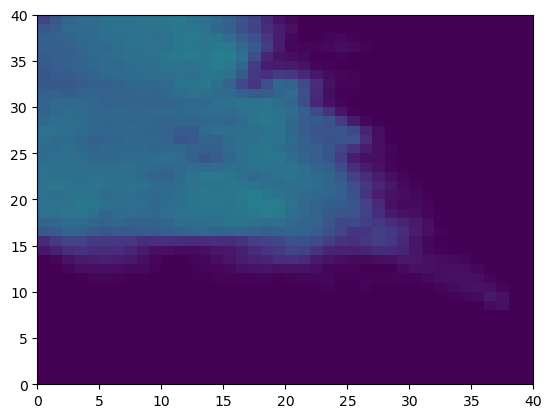

In [126]:
import matplotlib.pyplot as plt
plt.pcolormesh(ys[..., 200], vmin=np.min(ys), vmax=np.max(vmax))

In [53]:
m = np.loadtxt('/mnt/DATA/2D/pl_postech/spectrum/692.txt')
m.shape

(1600, 1601)

In [54]:
x0 = mat[:, 0]
x1 = m[:, 0]

In [74]:
mask = np.sum(np.abs(x1.reshape(-1,1) - x0.reshape(1,-1)) < np.mean(x0[1:] - x0[:-1])*0.5, axis=int(x1.shape[0] > x0.shape[0])).astype(bool)
np.sum(mask)

337

In [75]:
np.mean(x0[1:] - x0[:-1])*0.5, np.mean(x1[1:] - x1[:-1])*0.5

(0.08380803571428566, 0.0832351469668543)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [95]:
x0[1:] - x0[:-1]

array([0.167, 0.167, 0.167, 0.167, 0.167, 0.167, 0.167, 0.167, 0.167,
       0.167, 0.167, 0.167, 0.167, 0.167, 0.167, 0.167, 0.167, 0.166,
       0.167, 0.167, 0.167, 0.167, 0.167, 0.167, 0.167, 0.167, 0.167,
       0.167, 0.167, 0.166, 0.167, 0.167, 0.167, 0.167, 0.167, 0.167,
       0.167, 0.167, 0.166, 0.167, 0.167, 0.167, 0.167, 0.167, 0.167,
       0.167, 0.166, 0.167, 0.167, 0.167, 0.167, 0.167, 0.167, 0.167,
       0.166, 0.167, 0.167, 0.167, 0.167, 0.167, 0.167, 0.166, 0.167,
       0.167, 0.167, 0.167, 0.167, 0.166, 0.167, 0.167, 0.167, 0.167,
       0.167, 0.166, 0.167, 0.167, 0.167, 0.167, 0.166, 0.167, 0.167,
       0.167, 0.167, 0.166, 0.167, 0.167, 0.167, 0.167, 0.166, 0.167,
       0.167, 0.167, 0.167, 0.166, 0.167, 0.167, 0.167, 0.166, 0.167,
       0.167, 0.167, 0.167, 0.166, 0.167, 0.167, 0.167, 0.166, 0.167,
       0.167, 0.167, 0.166, 0.167, 0.167, 0.167, 0.166, 0.167, 0.167,
       0.167, 0.166, 0.167, 0.167, 0.166, 0.167, 0.167, 0.167, 0.166,
       0.167, 0.167,